In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [2]:
trainDir = "C:\\Users\\ronit\\Programming\\AI\\kaggle_data\\chest_xray\\train"
valiDir = "C:\\Users\\ronit\\Programming\\AI\\kaggle_data\\chest_xray\\val"
testDir = "C:\\Users\\ronit\\Programming\\AI\\kaggle_data\\chest_xray\\test"

trainTrans = transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor()])
valTrans = transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor()])

trainData = datasets.ImageFolder(
    trainDir,
    trainTrans
)

valiData = datasets.ImageFolder(
    valiDir,
    valTrans
)
testData = datasets.ImageFolder(
    testDir,
    trainTrans
)

batchsz = 32
trainloader = DataLoader(trainData, batch_size=batchsz, shuffle=True)
valiloader = DataLoader(valiData, batch_size=batchsz)
testloader = DataLoader(testData, batch_size=439)

print(len(trainloader.dataset.imgs), valiloader.dataset.classes)
print("The number of images in a test set is: ", len(valiloader))

print("The number of batches per epoch is: ", len(trainloader))

4100 ['NORMAL', 'PNEUMONIA']
The number of images in a test set is:  28
The number of batches per epoch is:  129


In [45]:
t = torch.randn(2, 2)
print(t.data)
a, b = torch.max(t, 1)
print(a)
print("b", b)

tensor([[-0.2940,  0.5948],
        [ 0.2613, -0.1767]])
tensor([0.5948, 0.2613])
b tensor([1, 0])


In [47]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1, True)
        )

        self.linear = nn.Sequential(
            nn.Linear(18496, 128),
            nn.ReLU(True),
            nn.Linear(128, 2),
            nn.Softmax(1)
        )


    def forward(self, x):
        x = self.conv(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.linear(x)
        #x = x.view(x.size(0), -1)
        #print(x.shape)
        # x = nn.functional.softmax(x, 1)
        return x

model = NeuralNetwork().to(device)
print(model)



Using cuda device
NeuralNetwork(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.1, inplace=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=18496, out_features=128, bias=True)
    (1): ReLU(inplace=True)
   

In [55]:
from torch.autograd import Variable
from torch.optim import Adam
 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
#loss_fn = nn.BCELoss
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# Function to save the model
def saveModel():
    path = "./lung_cancv4.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in valiloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            #outputs = outputs.view(outputs.size(0))

            #print("oo  ", outputs)
            #predicted = torch.round(outputs)
            
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    num = accuracy
    accuracy = float(100 * accuracy / total)
    return (float(accuracy))


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(trainloader, 0):
            # print(f"{i} here")

            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            #print("out", outputs.size(0))
            #outputs = outputs.view(outputs.size(0))
            loss = nn.CrossEntropyLoss()(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()
            print(f"{i} ", end = "")
            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 10 == 9: 
                # print every 1000 (twice per epoch) 
                print(('[%d, %5d] loss: %.5f' %
                      (epoch + 1, i + 1, running_loss / 1000)), end=" ")
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %.3f %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
#def testBatch():
    # get batch of images from the test DataLoader  
    #print(next(iter(testloader)))
    images, labels = next(iter(testloader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % trainloader.dataset.classes[labels[j]] 
                               for j in range(batchsz)))
  
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    predicted = torch.round(outputs.data)
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % trainloader.dataset.classes[predicted[j]] 
                              for j in range(batchsz)))

In [57]:
if __name__ == "__main__":
    
    # Let's build our model
    train(50)
    print('Finished Training')
    
    # Let's load the model we just created and test the accuracy per label
    model = NeuralNetwork()
    path = "lung_cancv4.pth"
    model.load_state_dict(torch.load(path))

    # Test with batch of images
    #testBatch()

The model will be running on cuda:0 device
0 1 2 3 4 5 6 7 8 9 [1,    10] loss: 0.00555 10 11 12 13 14 15 16 17 18 19 [1,    20] loss: 0.00538 20 21 22 23 24 25 26 27 28 29 [1,    30] loss: 0.00545 30 31 32 33 34 35 36 37 38 39 [1,    40] loss: 0.00560 40 41 42 43 44 45 46 47 48 49 [1,    50] loss: 0.00535 50 51 52 53 54 55 56 57 58 59 [1,    60] loss: 0.00582 60 61 62 63 64 65 66 67 68 69 [1,    70] loss: 0.00529 70 71 72 73 74 75 76 77 78 79 [1,    80] loss: 0.00526 80 81 82 83 84 85 86 87 88 89 [1,    90] loss: 0.00545 90 91 92 93 94 95 96 97 98 99 [1,   100] loss: 0.00538 100 101 102 103 104 105 106 107 108 109 [1,   110] loss: 0.00545 110 111 112 113 114 115 116 117 118 119 [1,   120] loss: 0.00485 120 121 122 123 124 125 126 127 128 For epoch 1 the test accuracy over the whole test set is 74.601 %
0 1 2 3 4 5 6 7 8 9 [2,    10] loss: 0.00520 10 11 12 13 14 15 16 17 18 19 [2,    20] loss: 0.00554 20 21 22 23 24 25 26 27 28 29 [2,    30] loss: 0.00523 30 31 32 33 34 35 36 37 38 39 

KeyboardInterrupt: 

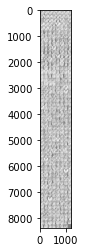

Real labels:  NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL
Predicted:  PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA


In [238]:
model = NeuralNetwork()
path = "lung_cancv2.pth"
model.load_state_dict(torch.load(path))
testBatch()

In [239]:
# Function to test what classes performed well
model.cuda()
def testClasses():
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(439):
                print(i, end=" ")
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(2):
        print('Accuracy of %5s : %2d %%' % (
            testloader.dataset.classes[i], 100 * class_correct[i] / class_total[i]))
    print("Overall acc: ", 100 * ((class_correct[0] + class_correct[1])/(class_total[0] + class_total[1])))
testClasses()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27